# Membuat Model NPL dengan Tensorflow


**Data Diri**
*   Nama : Ilham Dwi Yanto
*   Domisili : Madiun, Jawa Timur
*   Email : ilham.dy18@gmail.com 




In [1]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, SpatialDropout1D, Dense
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv('/content/bitcoin_articles.csv', usecols=['title', 'topic'])
df.head()

,title,topic
0,62% of Bitcoin Has Not Moved in a Year as Long...,finance
1,The Orange Party Issue Playlist,news
2,How Many Bitcoins Are There?,news
3,Bitcoin 2008–2022: From Bouncing Baby To Troub...,business
4,"Bitcoin Lightning Network capacity strikes 5,0...",news


In [3]:
df.shape

(2500, 2)

In [4]:
df.topic.value_counts()

news             1985
finance           388
business           79
tech               20
economics          11
world               6
entertainment       3
science             2
beauty              2
politics            1
sport               1
food                1
energy              1
Name: topic, dtype: int64

In [5]:
df.topic.loc[(df['topic'] == "economics") | (df['topic'] == "world") | (df['topic'] == "entertainment") | 
             (df['topic'] == "science") | (df['topic'] == "beauty") | (df['topic'] == "politics") | 
             (df['topic'] == "sport") | (df['topic'] == "food") | (df['topic'] == "energy") | 
             (df['topic'] == "tech")] = "others topic"

df.reset_index(inplace = True)
df.drop('index', axis='columns', inplace=True)

In [6]:
df.topic.value_counts()

news            1985
finance          388
business          79
others topic      48
Name: topic, dtype: int64

In [7]:
num_word = 50000

ubah_df = df.reindex(np.random.permutation(df.index))

news = ubah_df[ubah_df['topic'] == 'news'][:num_word]
finance = ubah_df[ubah_df['topic'] == 'finance'][:num_word]
business = ubah_df[ubah_df['topic'] == 'business'][:num_word]
others_topic = ubah_df[ubah_df['topic'] == 'others topic'][:num_word]

df_baru = pd.concat([news, finance, business, others_topic], ignore_index=True)

df_baru = df_baru.reindex(np.random.permutation(df_baru.index))
df_baru['label'] = 0

In [8]:
df_baru.loc[df_baru['topic'] == 'news', 'label'] = 0
df_baru.loc[df_baru['topic'] == 'finance', 'label'] = 1
df_baru.loc[df_baru['topic'] == 'business', 'label'] = 2
df_baru.loc[df_baru['topic'] == 'others topic', 'label'] = 3

print(df_baru['label'][:10])

8       0
265     0
638     0
56      0
2272    1
1213    0
2038    1
463     0
57      0
91      0
Name: label, dtype: int64


In [9]:
labels = to_categorical(df_baru['label'], num_classes=4)

print(labels[:10])

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [10]:
max_words = 5000
max_len = 150

tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', oov_token='x', lower=True)
tokenizer.fit_on_texts(df_baru['title'].values)
sequences = tokenizer.texts_to_sequences(df_baru['title'].values)
word_index = tokenizer.word_index
print('Ditemukan %s tokens unik.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

Ditemukan 3673 tokens unik.


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

In [12]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

((1875, 150), (1875, 4), (625, 150), (625, 4))


In [13]:
epochs = 20
emb_dim = 128
batch_size = 64

labels[:10]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [14]:
model = Sequential()
model.add(Embedding(max_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 128)          640000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 150, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 689,668
Trainable params: 689,668
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
history = model.fit(X_train, y_train, 
                    epochs=epochs, batch_size=batch_size,
                    validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)])

Epoch 1/20
24/24 [==============================] - 13s 391ms/step - loss: 0.9126 - accuracy: 0.7600 - val_loss: 0.7051 - val_accuracy: 0.7893
Epoch 2/20
24/24 [==============================] - 9s 365ms/step - loss: 0.6678 - accuracy: 0.7940 - val_loss: 0.6943 - val_accuracy: 0.7893
Epoch 3/20
24/24 [==============================] - 10s 407ms/step - loss: 0.6616 - accuracy: 0.7940 - val_loss: 0.6874 - val_accuracy: 0.7893
Epoch 4/20
24/24 [==============================] - 9s 369ms/step - loss: 0.6623 - accuracy: 0.7940 - val_loss: 0.6858 - val_accuracy: 0.7893
Epoch 5/20
24/24 [==============================] - 9s 397ms/step - loss: 0.6626 - accuracy: 0.7940 - val_loss: 0.6925 - val_accuracy: 0.7893
Epoch 6/20
24/24 [==============================] - 9s 372ms/step - loss: 0.6633 - accuracy: 0.7940 - val_loss: 0.6934 - val_accuracy: 0.7893
Epoch 7/20
24/24 [==============================] - 9s 368ms/step - loss: 0.6643 - accuracy: 0.7940 - val_loss: 0.7021 - val_accuracy: 0.7893
Epoc

In [16]:
accuracy = model.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accuracy[0],accuracy[1]))

20/20 [==============================] - 1s 35ms/step - loss: 0.6375 - accuracy: 0.7968
Test set
  Loss: 0.638
  Accuracy: 0.797


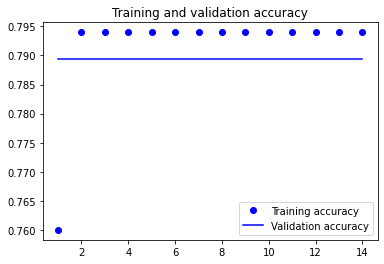

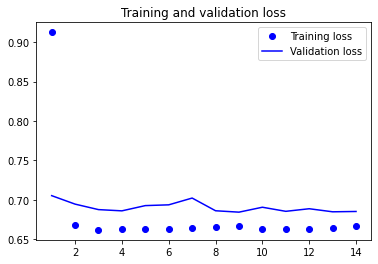

In [17]:
import matplotlib.pyplot as plt

accu = history.history['accuracy']
val_accu = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accu) + 1)

plt.plot(epochs, accu, 'bo', label='Training accuracy')
plt.plot(epochs, val_accu, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
ex_title = ["The Orange Party Issue Playlist"]
labels = ['news', 'bussiness', 'finance', 'others topic']

seq = tokenizer.texts_to_sequences(ex_title)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)

print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 421ms/step
[[0.7600826  0.17938441 0.03404971 0.02648323]] news
